# Real Cube: Motion Extraction & Mode Identification
This notebook shows how to extract image-space modal observations from a video of the real Jello cube. There are three videos of the real cube, each of a different initial condition:
1. `real_data/jello_cube/top_front_pluck/top_front_pluck-4000fps.avi`
2. `real_data/jello_cube/top_right_pluck/top_right_pluck-4000fps.avi`
3. `real_data/jello_cube/left_side_twist/left_side_twist-4000fps.avi`

This notebook will write a `modal_observations.pkl` file, which contains images of the identified image-space modes (in the horizontal and vertical directions) and their frequencies. It will also ask you to click on the locations of reference mesh points and save them in a `clicks.npy` file. These reference points will be used to sample image-space modes at visible mesh vertices in the `demo_real_cube_inference.ipynb` notebook.

In order to recreate Figs. 10 and 11 in the paper, you will need to run this notebook entirely for each of the three videos.

In [1]:
import pickle

import numpy as np
import matplotlib.pyplot as plt

import vvt

videos = ['top_front_pluck', 'top_right_pluck', 'left_side_twist']
fps = 4000

In [2]:
"""
Set which video to work with.
"""
video = 'left_side_twist'
assert video in videos

N_THREADS = 8  # num. threads to use in multithreaded functions

## Motion Extraction

Reading AVI: real_data/jello_cube/left_side_twist/left_side_twist-4000fps.avi


Reading frames: 100%|█████████████████████████████████████████████████████████████████████████████████████| 12101/12101 [00:01<00:00, 6114.67it/s]


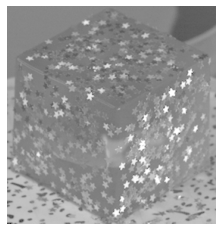

In [3]:
"""
Read the frames and show the first frame of the video.
"""
avi_fn = 'real_data/jello_cube/%s/%s-%dfps.avi' % (video, video, fps)
print('Reading AVI:', avi_fn)

frames = vvt.motion.read_frames(avi_fn)
plt.imshow(frames[0], cmap='gray')
plt.axis('off')
plt.show()

In [4]:
"""
Run motion extraction and then apply amplitude-weighted Gaussian smoothing to the 
displacement fields.
"""
# Some videos have large motion at the beginning, so we have to start from a later frame.
start_frames = {
    'top_front_pluck': 1000,
    'top_right_pluck': 1000,
    'left_side_twist': 0
}
t_start, t_end = start_frames[video], len(frames)
ref_frame = frames[t_start]
motion_fields = vvt.motion.extract_motion(
    frames[t_start:t_end], ref_frame, filter_pct=98, n_threads=N_THREADS)
motion_fields = vvt.motion.weighted_gaussian_smooth(
    motion_fields, ref_frame, sigma=4, n_threads=N_THREADS)

Running motion extraction in 8 threads...
[Thread 0] 100 / 1512 frames processed in 9.1 seconds.
[Thread 0] 200 / 1512 frames processed in 9.4 seconds.
[Thread 0] 300 / 1512 frames processed in 8.8 seconds.
[Thread 0] 400 / 1512 frames processed in 9.3 seconds.
[Thread 0] 500 / 1512 frames processed in 8.7 seconds.
[Thread 0] 600 / 1512 frames processed in 9.0 seconds.
[Thread 0] 700 / 1512 frames processed in 8.9 seconds.
[Thread 0] 800 / 1512 frames processed in 9.3 seconds.
[Thread 0] 900 / 1512 frames processed in 8.7 seconds.
[Thread 0] 1000 / 1512 frames processed in 8.8 seconds.
[Thread 0] 1100 / 1512 frames processed in 8.9 seconds.
[Thread 0] 1200 / 1512 frames processed in 8.8 seconds.
[Thread 0] 1300 / 1512 frames processed in 8.9 seconds.
[Thread 0] 1400 / 1512 frames processed in 8.6 seconds.
[Thread 0] 1500 / 1512 frames processed in 9.1 seconds.
Done! Elapsed time: 0:02:16.523975
Running amplitude-weighted Gaussian smoothing in 8 threads...
[Thread 0] 500 / 1512 frames p

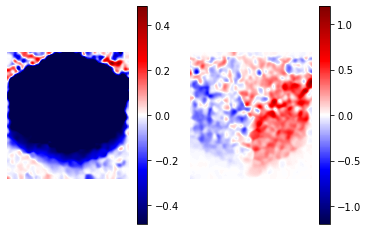

In [5]:
"""
View the displacement field at one frame.
"""
t = 1200
plt.subplot(121)
vvt.vis.plot_motion_field(motion_fields[0][t])
plt.subplot(122)
vvt.vis.plot_motion_field(motion_fields[1][t])

## Mode Identification

In [6]:
"""
Run 1D FFT on displacement fields.
`fft_dx[i]` contains the FFT coefficients of horizontal motion at FFT bin i.
`fft_dy[i]` contains the FFT coefficients of vertical motion at FFT bin i.
`spectrum` is the power spectrum of horizontal + vertical motion amplitude.
`ffreqs[i]` is the frequency [Hz] of FFT bin i.
"""
max_fft_freq = 50  # max. frequency (in Hz) to consider
fft_dx, fft_dy, spectrum, ffreqs = vvt.modes.get_fft_results(
    motion_fields, fps, max_fft_freq, n_threads=N_THREADS)
log_spectrum = np.log(spectrum)

Running FFT in 8 threads...
[Thread 0] 5 / 36 rows processed in 6.1 seconds.
[Thread 0] 10 / 36 rows processed in 6.1 seconds.
[Thread 0] 15 / 36 rows processed in 6.1 seconds.
[Thread 0] 20 / 36 rows processed in 6.1 seconds.
[Thread 0] 25 / 36 rows processed in 6.1 seconds.
[Thread 0] 30 / 36 rows processed in 6.1 seconds.
[Thread 0] 35 / 36 rows processed in 6.0 seconds.
Done! Elapsed time: 0:00:43.302491


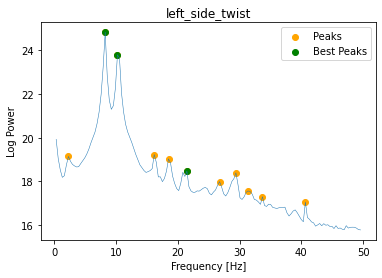

In [7]:
"""
Find peaks in the log-power spectrum of motion amplitude.
`best_peak_idxs_per_video` contains the best peaks that were
selected qualitatively.
"""
best_peak_idxs_per_video = {
    'top_front_pluck': [21, 25, 59],  # FFT bin indices
    'top_right_pluck': [25, 32, 60, 99],
    'left_side_twist': [25, 31, 65],
}
max_fft_idx = vvt.utils.find_nearest(ffreqs, max_fft_freq)
peak_idxs = vvt.modes.find_peak_idxs(log_spectrum[:max_fft_idx], prominence=0.01)
best_peak_idxs = best_peak_idxs_per_video[video]

plt.plot(ffreqs[1:max_fft_idx], log_spectrum[1:max_fft_idx], linewidth=0.5)
plt.scatter(
    ffreqs[peak_idxs], log_spectrum[peak_idxs], color='orange',
    label='Peaks')
plt.scatter(
    ffreqs[best_peak_idxs], log_spectrum[best_peak_idxs], color='green',
    label='Best Peaks')
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('Log Power')
plt.title(video)
plt.show()

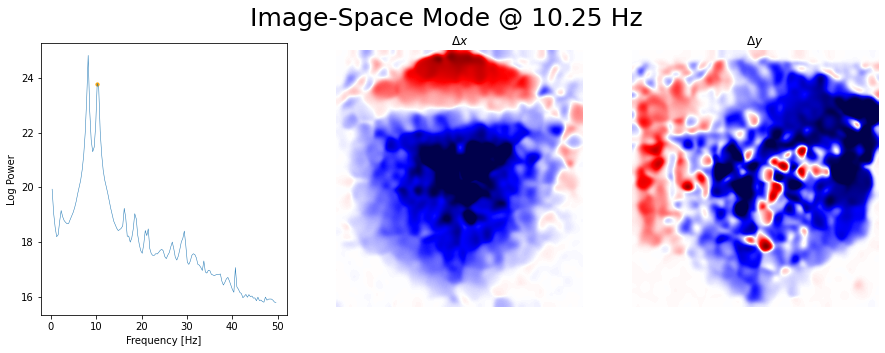

In [8]:
"""
View a specified image-space mode.
"""
fft_idx = best_peak_idxs[1]

mode_shape_dx = fft_dx[fft_idx].real
mode_shape_dy = fft_dy[fft_idx].real
mode_freq = ffreqs[fft_idx]

fig = plt.figure(figsize=(15, 5))
fig.suptitle('Image-Space Mode @ %.2f Hz' % mode_freq, fontsize=25)

plt.subplot(131)
plt.plot(ffreqs[1:max_fft_idx], log_spectrum[1:max_fft_idx], linewidth=0.5)
plt.scatter(ffreqs[fft_idx], log_spectrum[fft_idx], c='orange', s=10)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Log Power')

plt.subplot(132)
vvt.vis.plot_motion_field(mode_shape_dx, cbar=False)
plt.title('$\Delta x$')
plt.axis('off')

plt.subplot(133)
vvt.vis.plot_motion_field(mode_shape_dy, cbar=False)
plt.title('$\Delta y$')
plt.axis('off')
plt.show()

In [9]:
"""
Take the image-space modes at the best peaks, and save them as
modal observation data.
"""
extracted_modes_dx = np.array([fft_dx[i] for i in best_peak_idxs])
extracted_modes_dy = np.array([fft_dy[i] for i in best_peak_idxs])
extracted_freqs = ffreqs[best_peak_idxs]

data_dict = {
    'modes_dx': extracted_modes_dx,
    'modes_dy': extracted_modes_dy,
    'freqs': extracted_freqs
}

modal_data_file = 'real_data/jello_cube/%s/modal_observations.pkl' % video
with open(modal_data_file, 'wb') as fp:
    pickle.dump(data_dict, fp)
print('Wrote:', modal_data_file)

Wrote: real_data/jello_cube/left_side_twist/modal_observations.pkl


## Reference Keypoints
We will need the pixel locations of reference mesh points (i.e., the 7 visible corners).
Click the following points in the exact order:
1. bottom left
2. bottom middle
3. bottom right
4. top left back
5. top left front
6. top right back
7. top right front

<IPython.core.display.Javascript object>


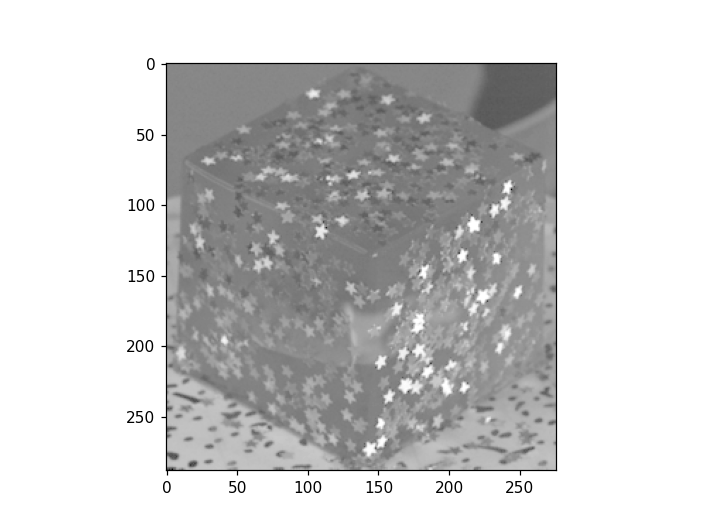

In [16]:
"""
Click on the locations of the 7 reference points.
"""
%matplotlib notebook
clicks = []
vvt.utils.prompt_clicks(ref_frame, clicks, cmap='gray')

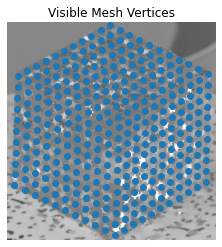

In [17]:
"""
Save the clicked locations and view them on a video frame.
"""
np.save('real_data/jello_cube/%s/clicks.npy' % video, clicks)
keypoints = vvt.utils.keypoints_from_clicks(clicks, 10, 10, 10)

plt.close('all')
%matplotlib inline
plt.imshow(ref_frame, cmap='gray')
plt.scatter(keypoints[:, 0], keypoints[:, 1])
plt.axis('off')
plt.title('Visible Mesh Vertices')
plt.show()